In [215]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pydot
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV



%matplotlib inline

In [216]:
df = pd.read_csv("CaseStudyData.csv")

/Users/chihcheng/.virtualenvs/python3env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


 # 1. What is the proportion of cars who can be classified as a “kick”? 

In [217]:
df.columns

Index(['PurchaseID', 'PurchaseTimestamp', 'PurchaseDate', 'Auction', 'VehYear',
       'Make', 'Color', 'Transmission', 'WheelTypeID', 'WheelType', 'VehOdo',
       'Nationality', 'Size', 'TopThreeAmericanName',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
       'MMRCurrentRetailRatio', 'PRIMEUNIT', 'AUCGUART', 'VNST', 'VehBCost',
       'IsOnlineSale', 'WarrantyCost', 'ForSale', 'IsBadBuy'],
      dtype='object')

In [218]:
len(df)

41476

In [219]:
proportionOfKicks = len(df[df['IsBadBuy'] == 1]) / len(list(df['IsBadBuy']))

In [220]:
print("The proportion of kicks: ", proportionOfKicks)

The proportion of kicks:  0.1294965763333012


# 2. Did you have to fix any data quality problems? Detail them.

In [221]:
drop_cols = ['PurchaseID','PurchaseDate']
categorial_cols = ['Auction', 'VehYear', 'Make', 'Color', 'Transmission','WheelTypeID', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName','PRIMEUNIT','AUCGUART','VNST','IsOnlineSale','ForSale' ] # Replaced by the most common 
interval_cols = ['PurchaseTimestamp', 'VehOdo','MMRAcquisitionAuctionAveragePrice','MMRAcquisitionAuctionCleanPrice','MMRAcquisitionRetailAveragePrice','MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice','MMRCurrentAuctionCleanPrice','MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice','MMRCurrentRetailRatio','VehBCost','WarrantyCost' ] # Replaced by the mean
replaced_vals = ['?', '#VALUE!']

for replaced in replaced_vals:
        df.replace(replaced, float('nan'),inplace = True)

In [222]:
print("Total null: ", df.isnull().sum().sum() )

Total null:  85508


In [223]:
from collections import defaultdict
nullValues = defaultdict(int)
for colName in df.columns:
    print("Column " + str(colName) + " has " + str(df[colName].isnull().sum()) +" null values")
    nullValues[colName] = df[colName].isnull().sum()

Column PurchaseID has 0 null values
Column PurchaseTimestamp has 0 null values
Column PurchaseDate has 0 null values
Column Auction has 44 null values
Column VehYear has 44 null values
Column Make has 44 null values
Column Color has 50 null values
Column Transmission has 50 null values
Column WheelTypeID has 1819 null values
Column WheelType has 1873 null values
Column VehOdo has 44 null values
Column Nationality has 47 null values
Column Size has 47 null values
Column TopThreeAmericanName has 47 null values
Column MMRAcquisitionAuctionAveragePrice has 67 null values
Column MMRAcquisitionAuctionCleanPrice has 54 null values
Column MMRAcquisitionRetailAveragePrice has 54 null values
Column MMRAcquisitonRetailCleanPrice has 156 null values
Column MMRCurrentAuctionAveragePrice has 231 null values
Column MMRCurrentAuctionCleanPrice has 231 null values
Column MMRCurrentRetailAveragePrice has 251 null values
Column MMRCurrentRetailCleanPrice has 251 null values
Column MMRCurrentRetailRatio h

In [224]:
def data_prep(df):
    
    
    # Making sure the replaced_vals doesn't exist in the dataframe
    for replaced in replaced_vals:
        df.replace(replaced, float('nan'),inplace = True)
    
    for colName in df.columns:
        
        if colName in categorial_cols:
            
            try:
                df[colName] = df[colName].str.lower()
            except:
                print(colName, " can't be transformed")

            df[colName] = df[colName].astype('category')
            
            df[colName].fillna(df[colName].astype('category').describe()['top'], inplace=True)
        
        if colName in interval_cols:
            
            df[colName] = df[colName].astype('float')
            
            # Removing outlier
            df = df[df[colName] < df[colName].quantile(0.999)]
            
            df[colName].fillna(df[colName].astype('float').mean(), inplace=True)
            
    df.drop(drop_cols, axis=1, inplace = True)
    
    # one-hot encoding
#     df = pd.get_dummies(df)
    
    return df

In [225]:
df = data_prep(df)

/Users/chihcheng/.virtualenvs/python3env/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/chihcheng/.virtualenvs/python3env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/chihcheng/.virtualenvs/python3env/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

VehYear  can't be transformed


/Users/chihcheng/.virtualenvs/python3env/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [226]:
df

,PurchaseTimestamp,Auction,VehYear,Make,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,...,MMRCurrentRetailCleanPrice,MMRCurrentRetailRatio,PRIMEUNIT,AUCGUART,VNST,VehBCost,IsOnlineSale,WarrantyCost,ForSale,IsBadBuy
0,1.253232e+09,other,2008.0,dodge,red,auto,2,covers,51099.0,american,...,12505.0,0.941783,no,green,nc,7800.0,0,920.0,yes,0
1,1.253232e+09,other,2008.0,dodge,red,auto,2,covers,48542.0,american,...,10571.0,0.922618,no,green,nc,7800.0,0,834.0,yes,0
2,1.253232e+09,other,2008.0,chrysler,silver,auto,2,covers,46318.0,american,...,9932.0,0.935159,no,green,nc,7800.0,0,834.0,yes,0
3,1.253232e+09,other,2008.0,chevrolet,red,auto,2,covers,50413.0,american,...,8739.0,0.931457,no,green,nc,6000.0,0,671.0,yes,0
4,1.253232e+09,other,2008.0,dodge,silver,auto,2,covers,50199.0,american,...,9908.0,0.906944,no,green,nc,7800.0,0,920.0,yes,0
6,1.253232e+09,other,2008.0,chrysler,silver,auto,2,covers,48433.0,american,...,9712.0,0.942133,no,green,nc,7800.0,0,834.0,yes,0
7,1.253232e+09,other,2008.0,pontiac,white,auto,2,covers,51062.0,american,...,13074.0,0.913110,no,green,nc,7500.0,0,671.0,yes,0
8,1.253232e+09,other,2008.0,pontiac,blue,auto,2,covers,59825.0,american,...,14135.0,0.909586,no,green,nc,7800.0,0,1500.0,yes,0
9,1.253232e+09,other,2008.0,chrysler,beige,auto,2,covers,49558.0,american,...,9712.0,0.942133,no,green,nc,7800.0,0,834.0,yes,0
10,1.253232e+09,other,2008.0,dodge,black,auto,2,covers,50569.0,american,...,9908.0,0.906944,no,green,nc,7800.0,0,920.0,yes,0


In [227]:
# Column PurchaseID -> droped
# Column PurchaseTimestamp -> int
# Column PurchaseDate -> int
# Column Auction -> cat
# Column VehYear -> cat
# Column Make -> cat 
# Column Color -> cat
# Column Transmission -> cat
# Column WheelTypeID -> cat
# Column WheelType -> cat
# Column VehOdo -> int
# Column Nationality -> cat
# Column Size -> cat
# Column TopThreeAmericanName -> cat
# Column MMRAcquisitionAuctionAveragePrice -> int 
# Column MMRAcquisitionAuctionCleanPrice -> int
# Column MMRAcquisitionRetailAveragePrice -> int
# Column MMRAcquisitonRetailCleanPrice -> int
# Column MMRCurrentAuctionAveragePrice -> int
# Column MMRCurrentAuctionCleanPrice -> int
# Column MMRCurrentRetailAveragePrice -> int
# Column MMRCurrentRetailCleanPrice -> int 
# Column MMRCurrentRetailRatio -> int 
# Column PRIMEUNIT -> cat 
# Column AUCGUART -> cat
# Column VNST -> cat
# Column VehBCost -> int 
# Column IsOnlineSale -> cat <Removing the outliner, data cleaning, -1 should be unknown>
# Column WarrantyCost -> int
# Column ForSale -> cat <data Cleaning>  if str .lower()
# Column IsBadBuy -> bool

# # AUCGUART & PRIMEUNIT -> lost together

# 3. Can you identify any clear patterns by initial exploration of the data using histogram or box plot?

In [228]:
def plotAllCols (df):
    for colName in df.columns:
        plt.figure(figsize=(20,10))
        if colName in categorial_cols:
            sns.countplot(x=colName, data = df, hue="IsBadBuy")
        elif colName in interval_cols:
            sns.boxplot(x="IsBadBuy", y=colName, data = df )

/Users/chihcheng/.virtualenvs/python3env/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


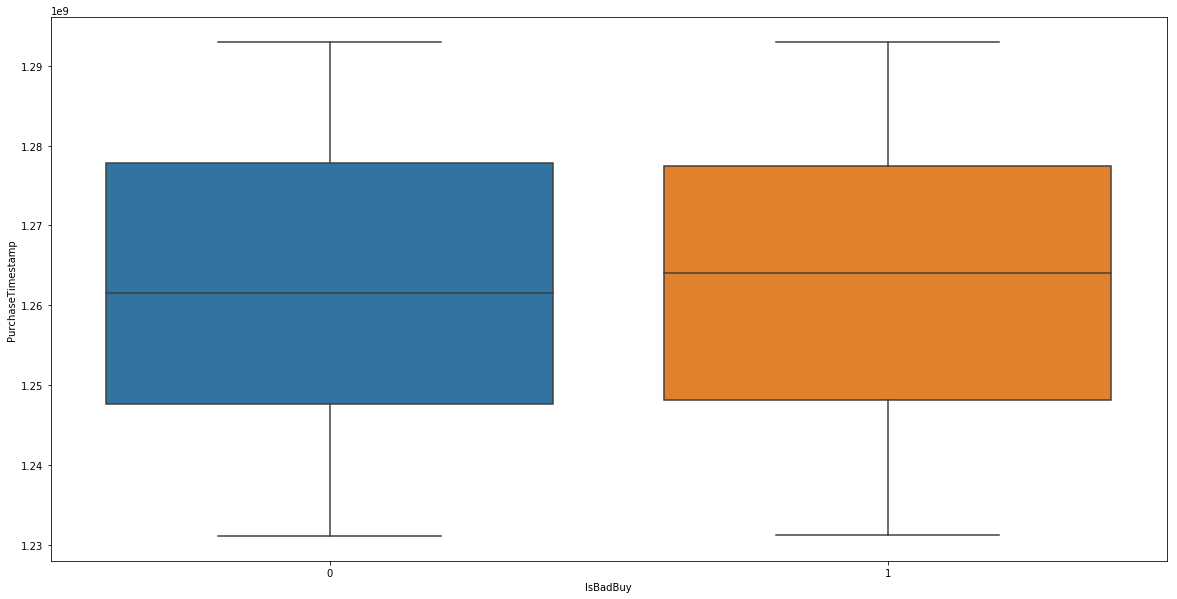

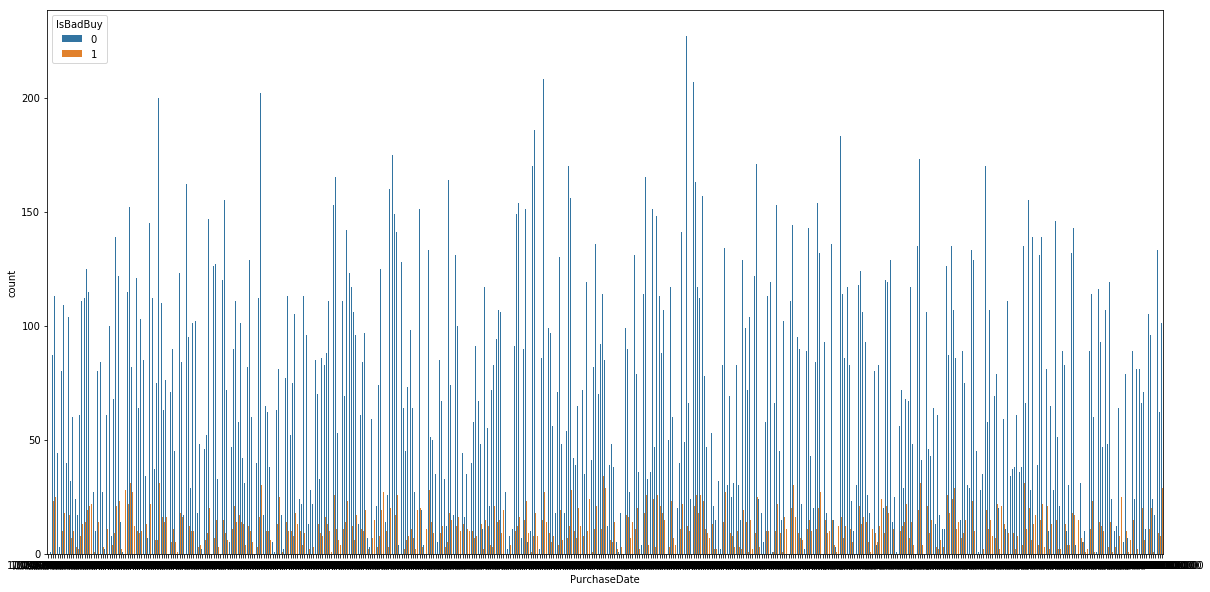

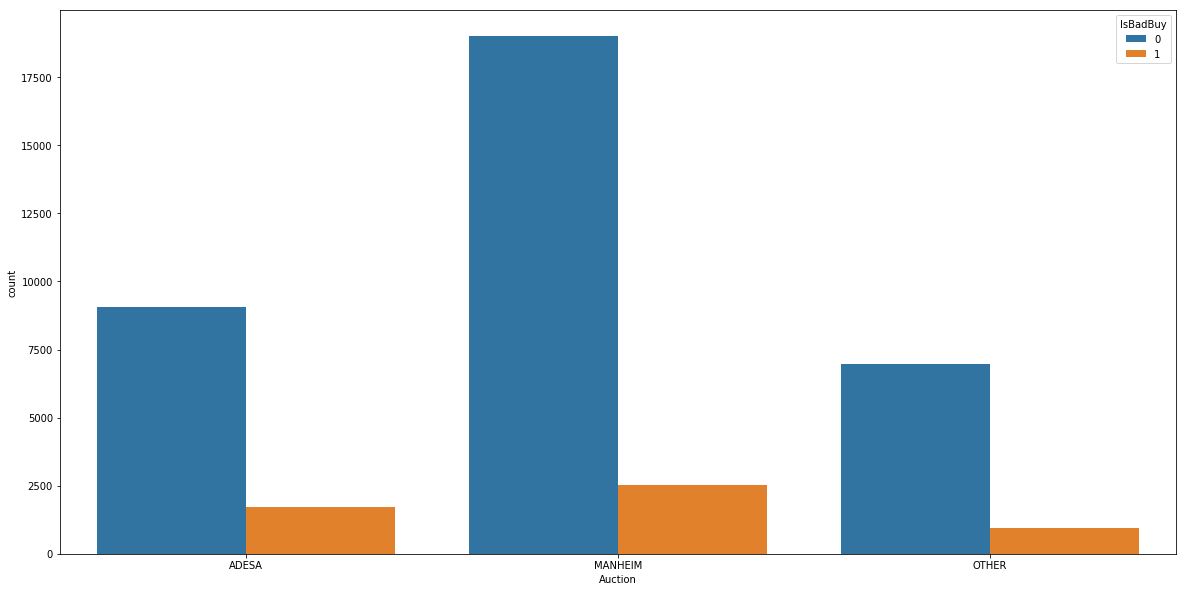

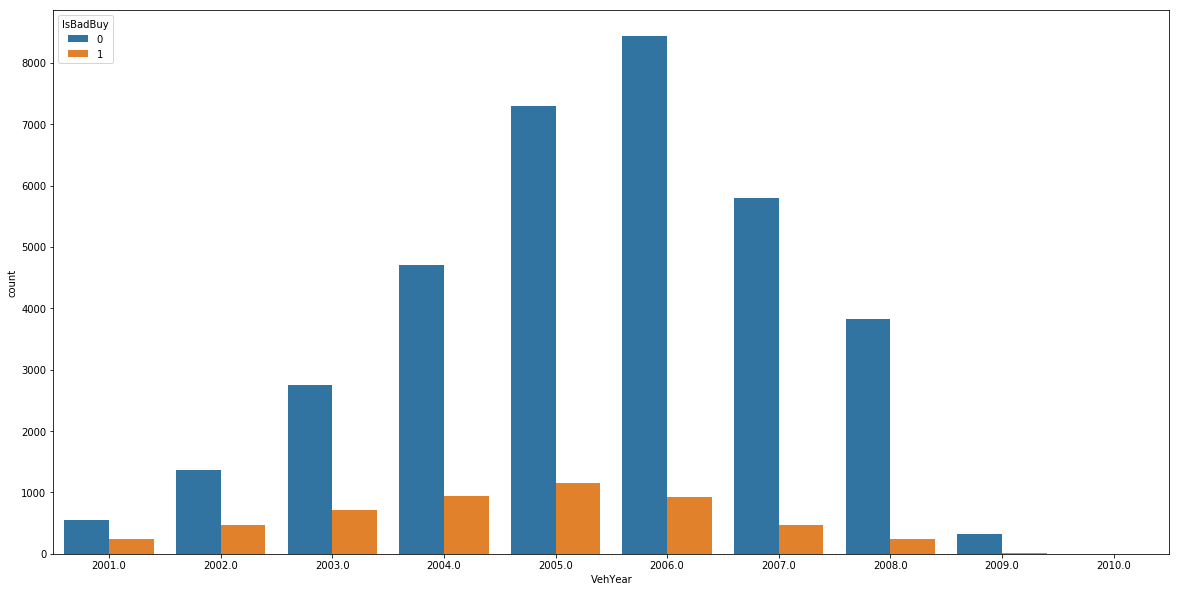

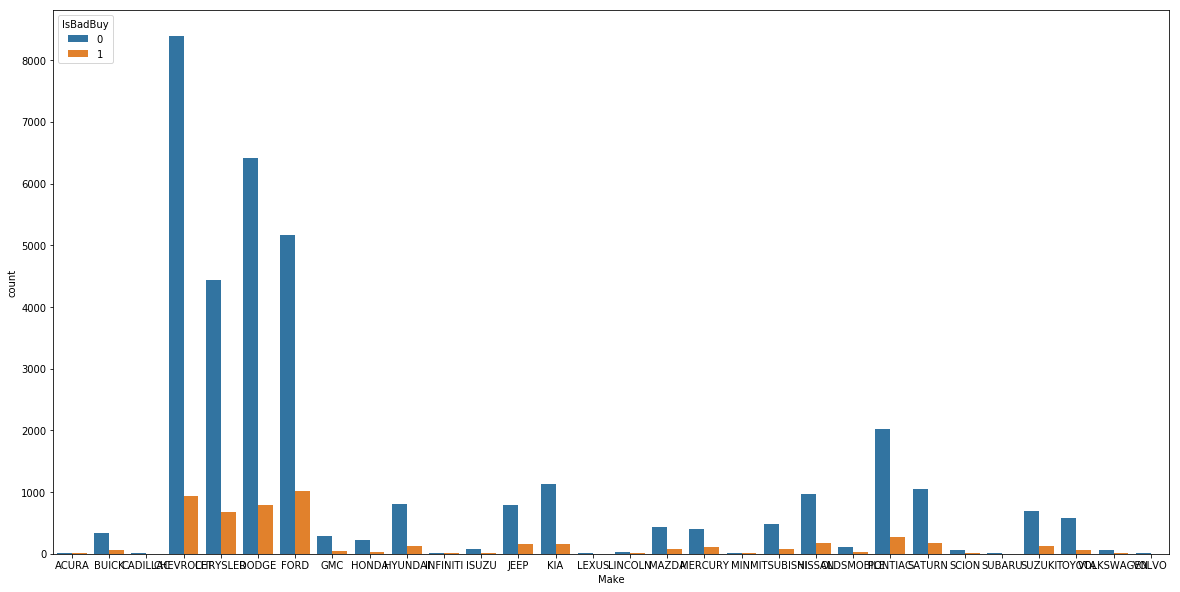

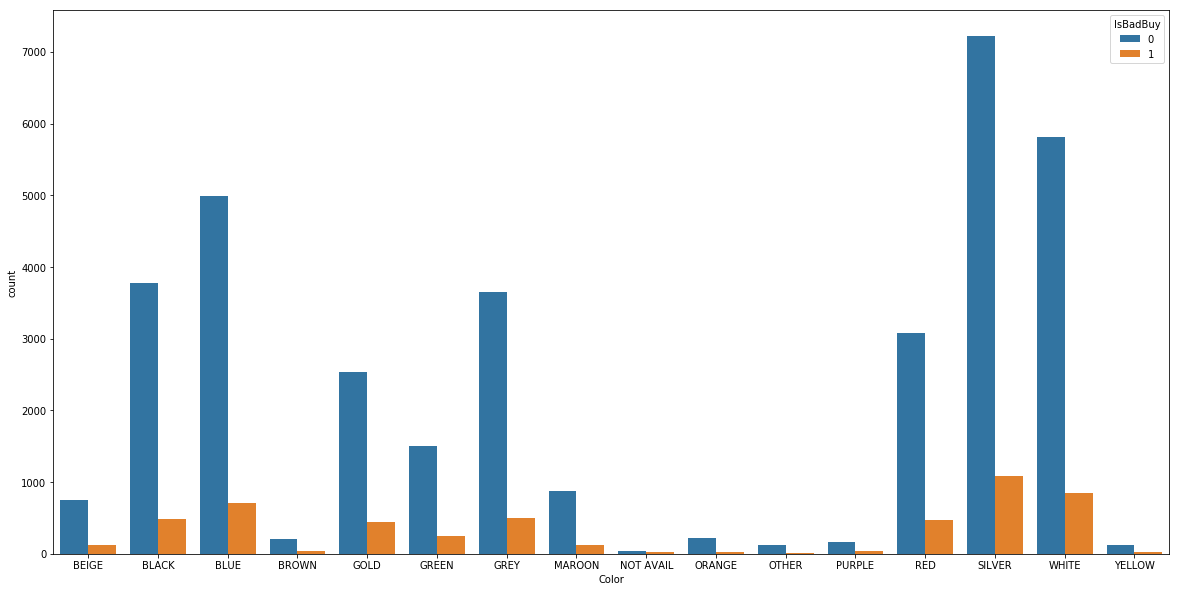

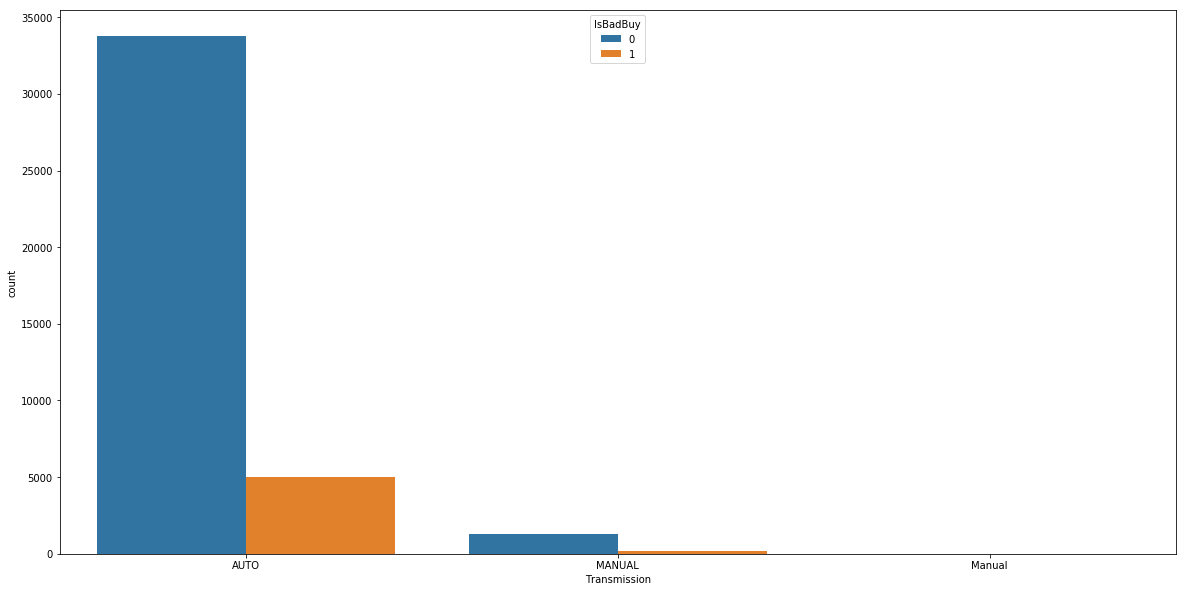

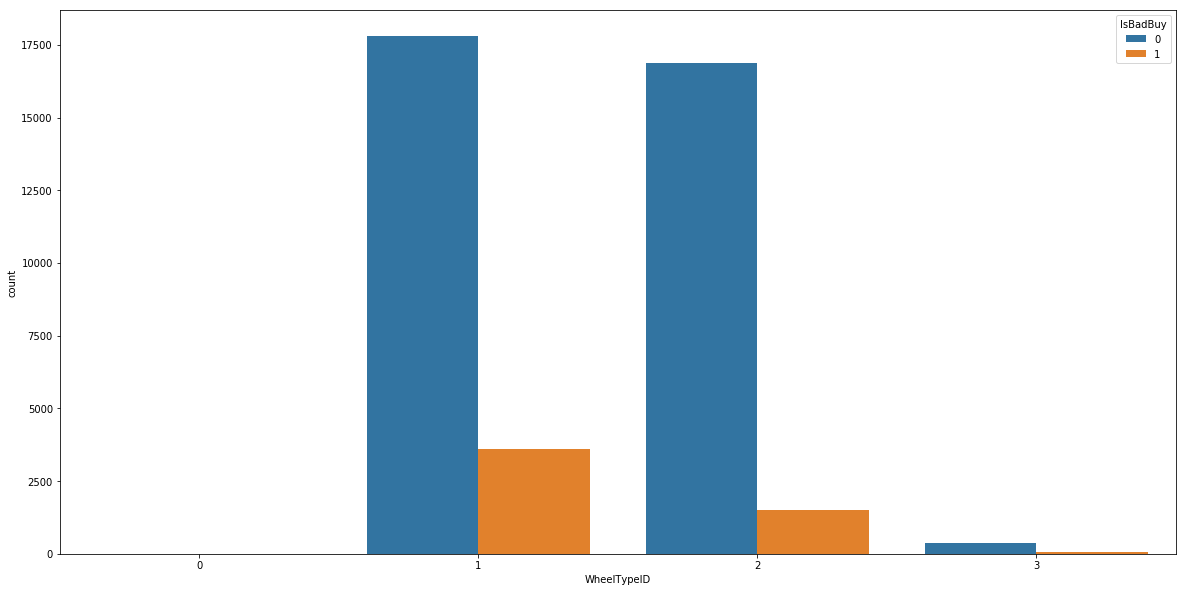

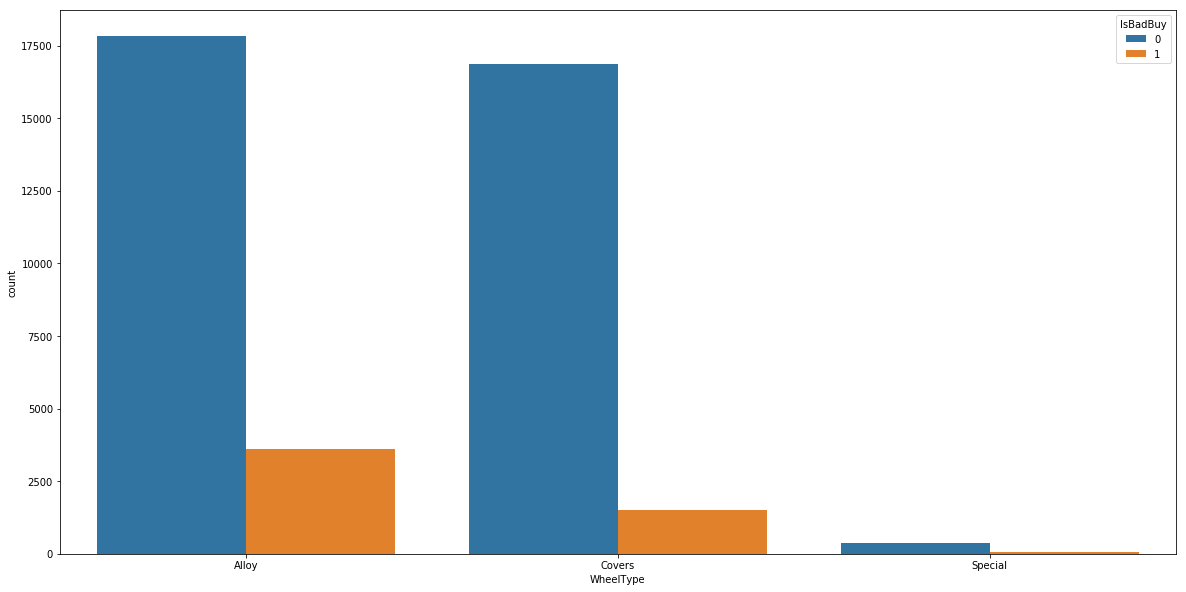

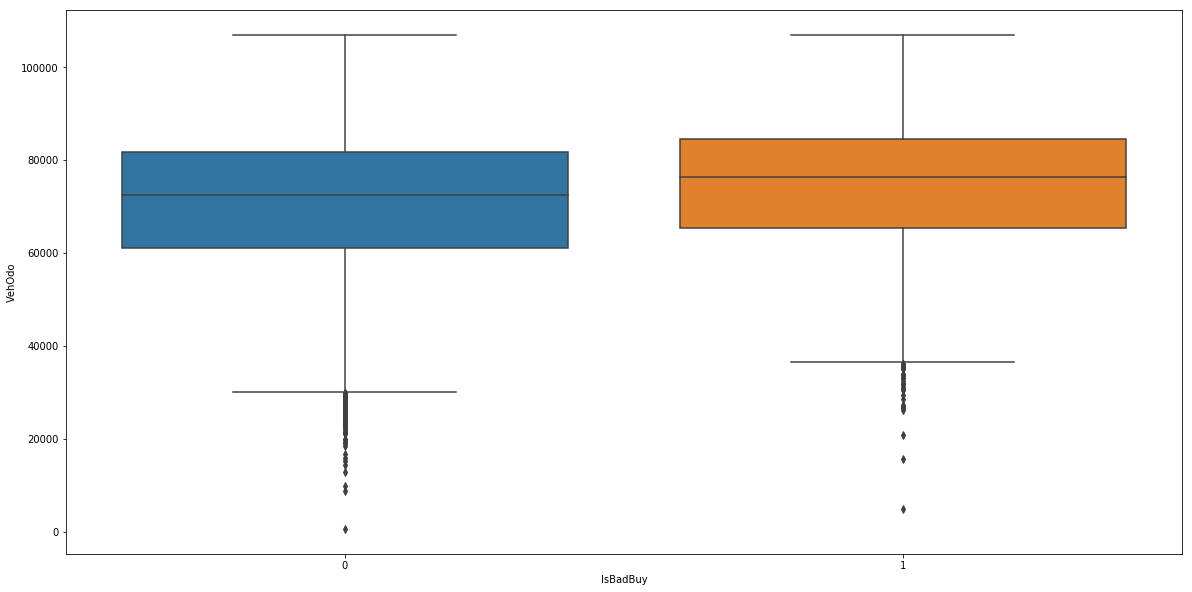

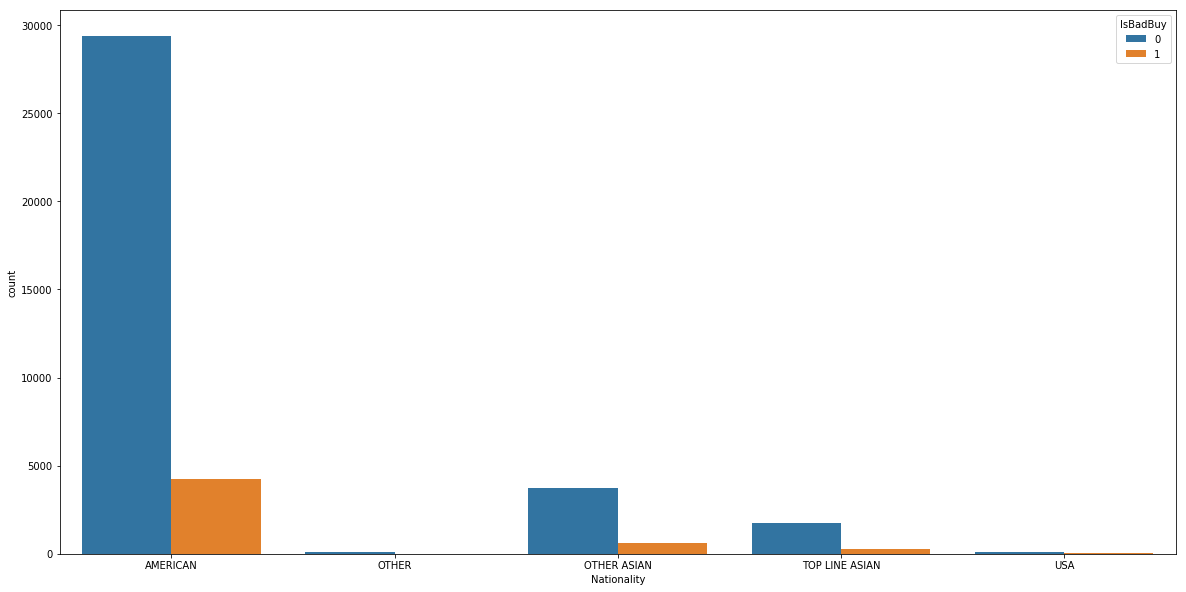

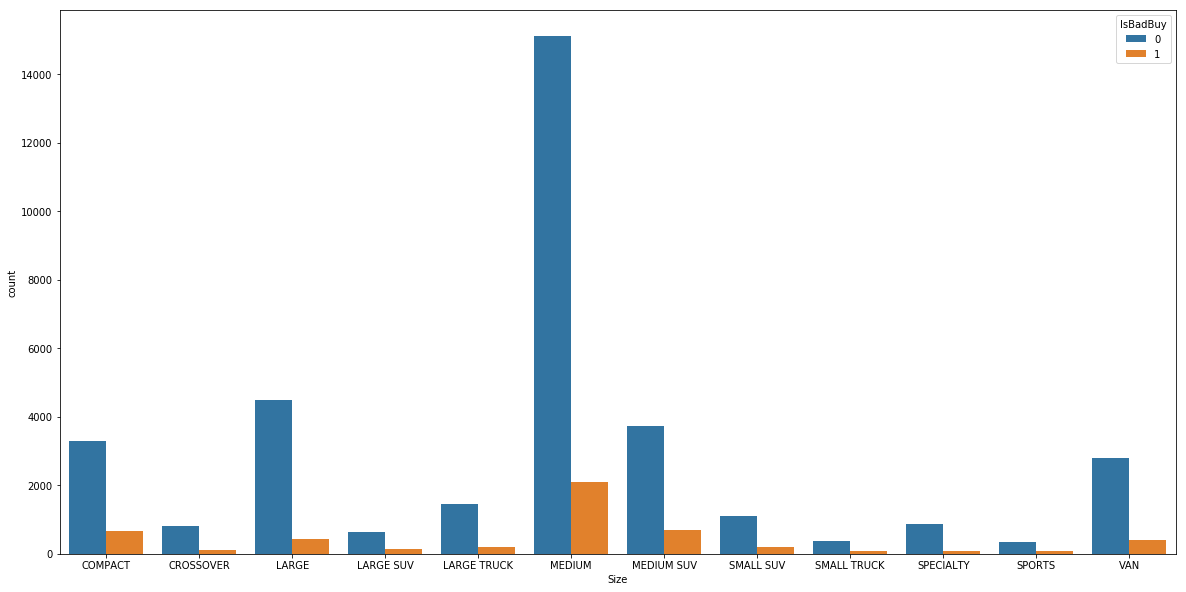

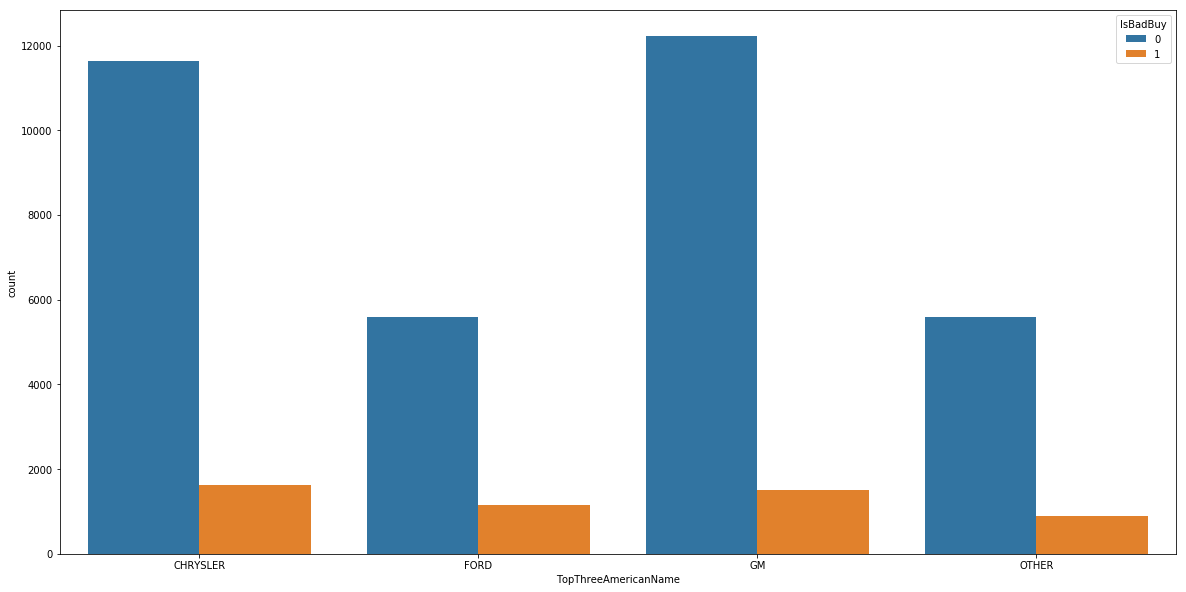

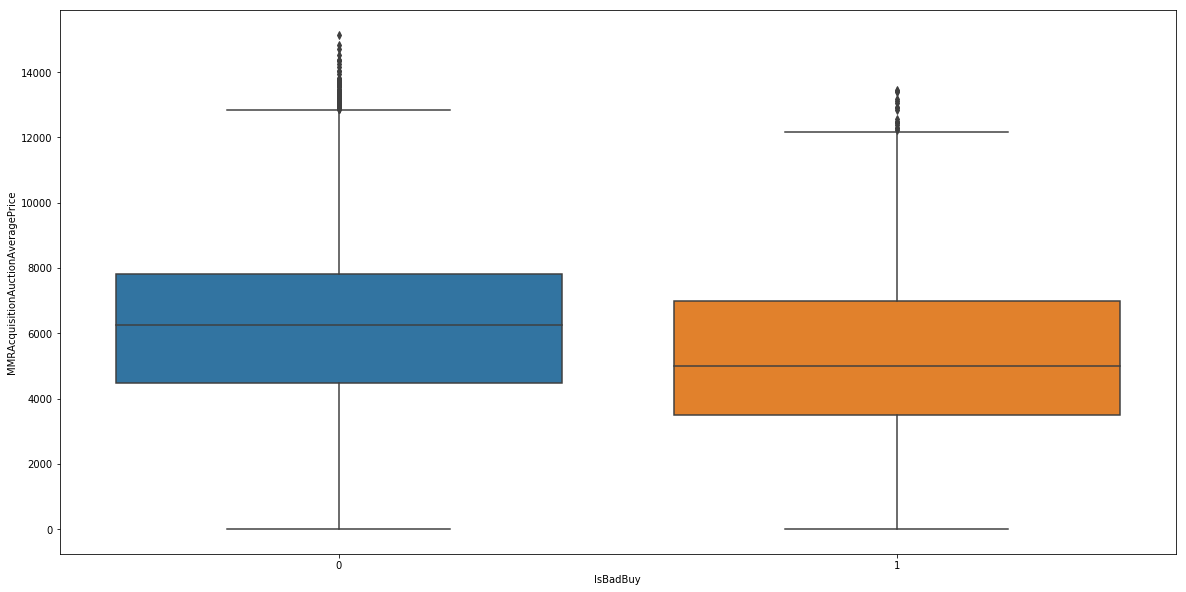

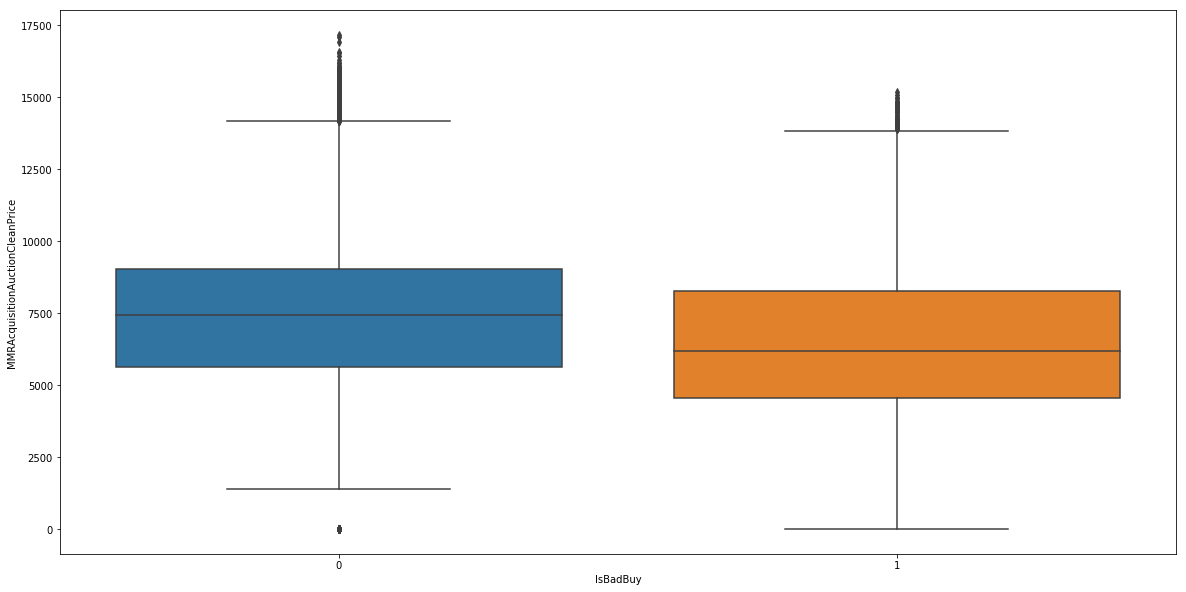

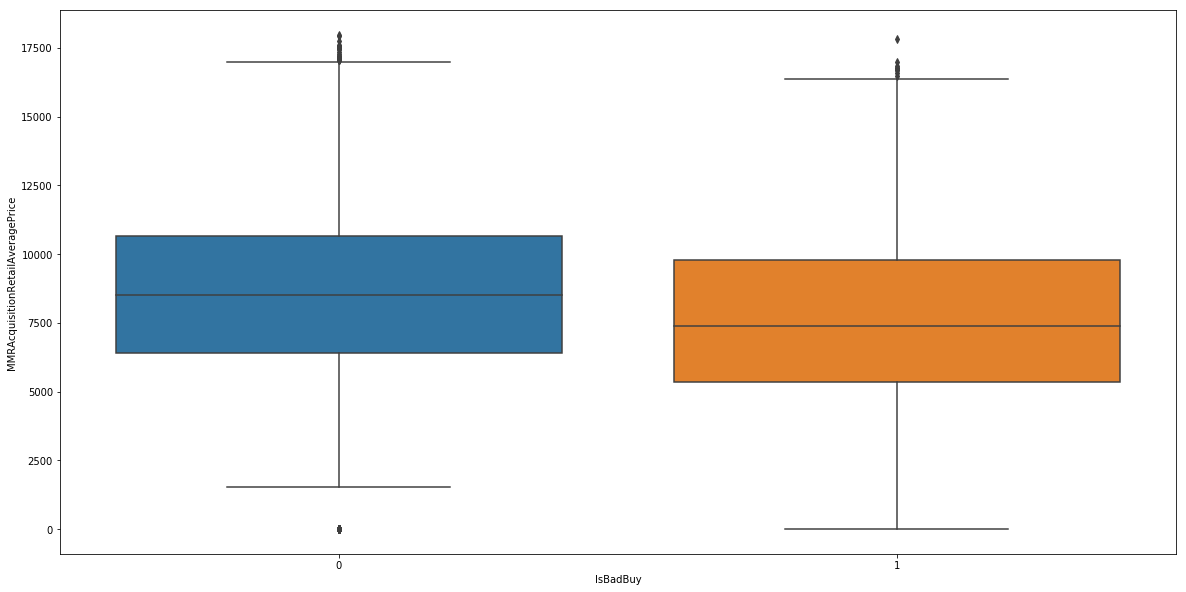

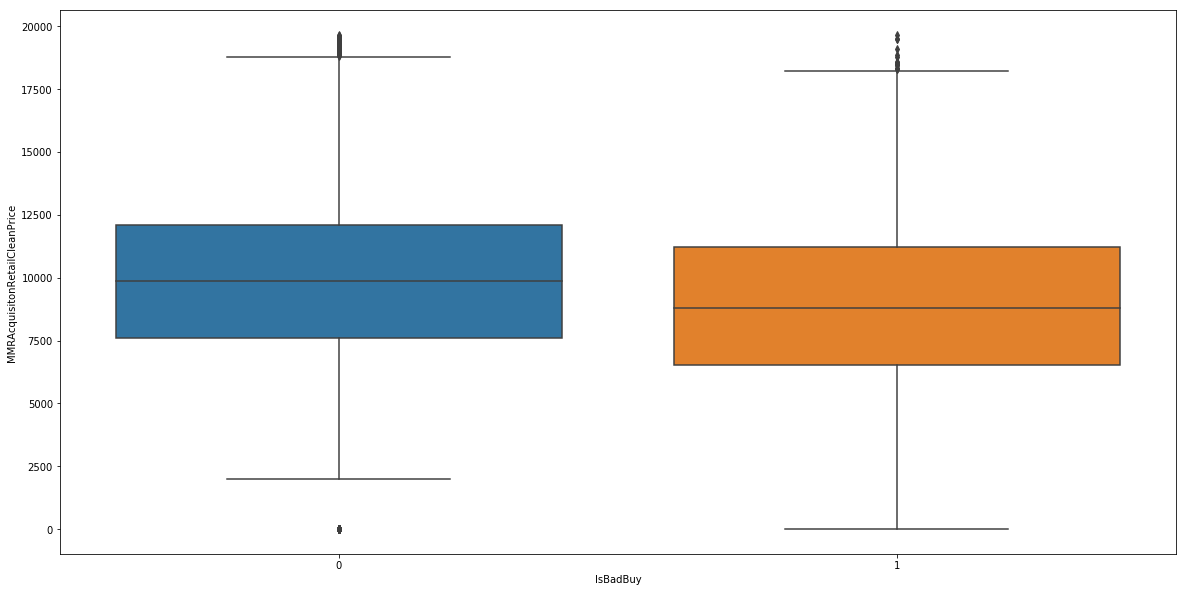

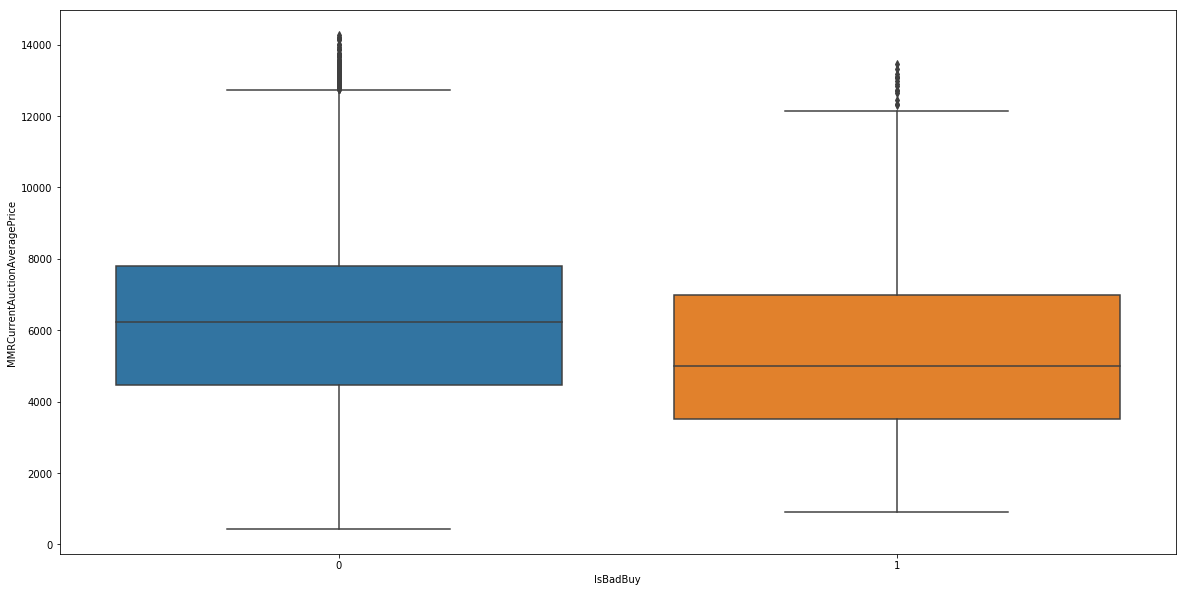

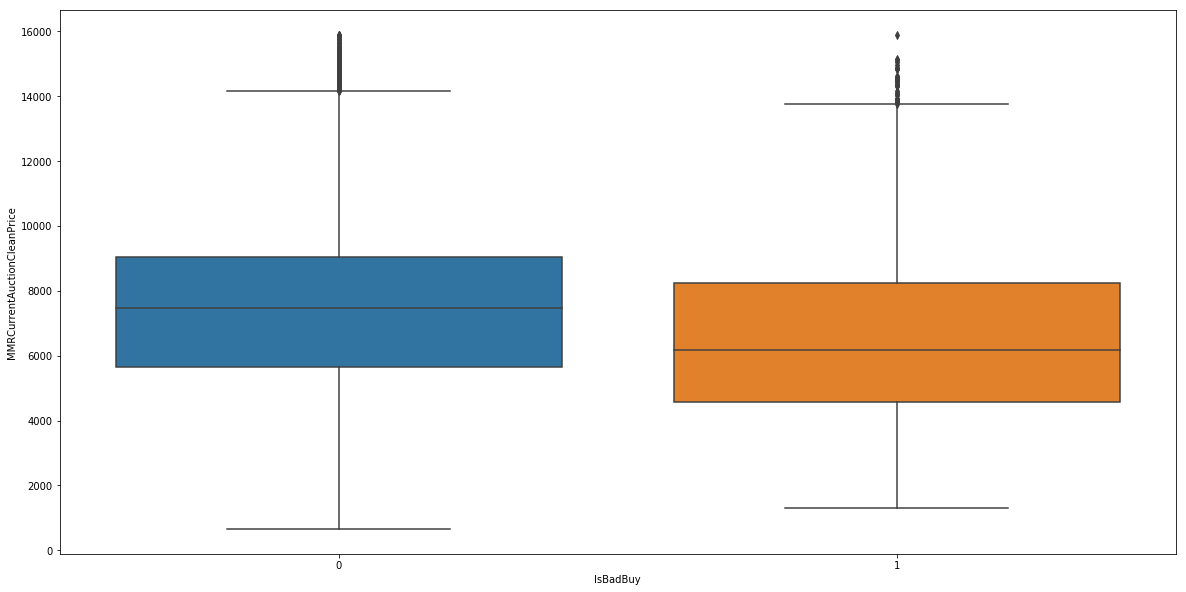

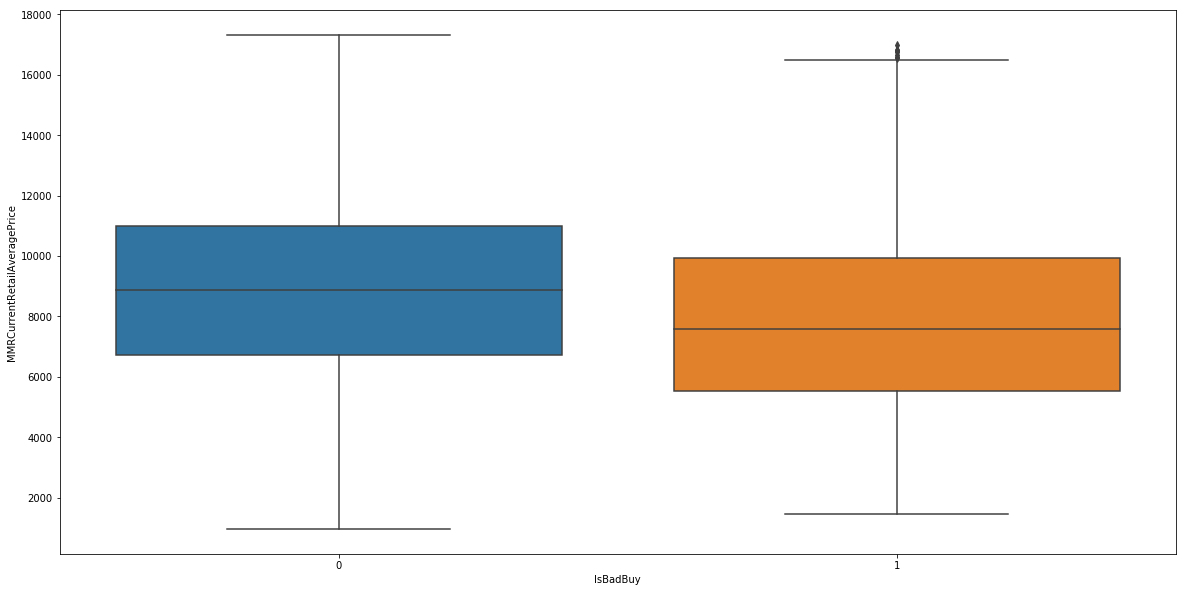

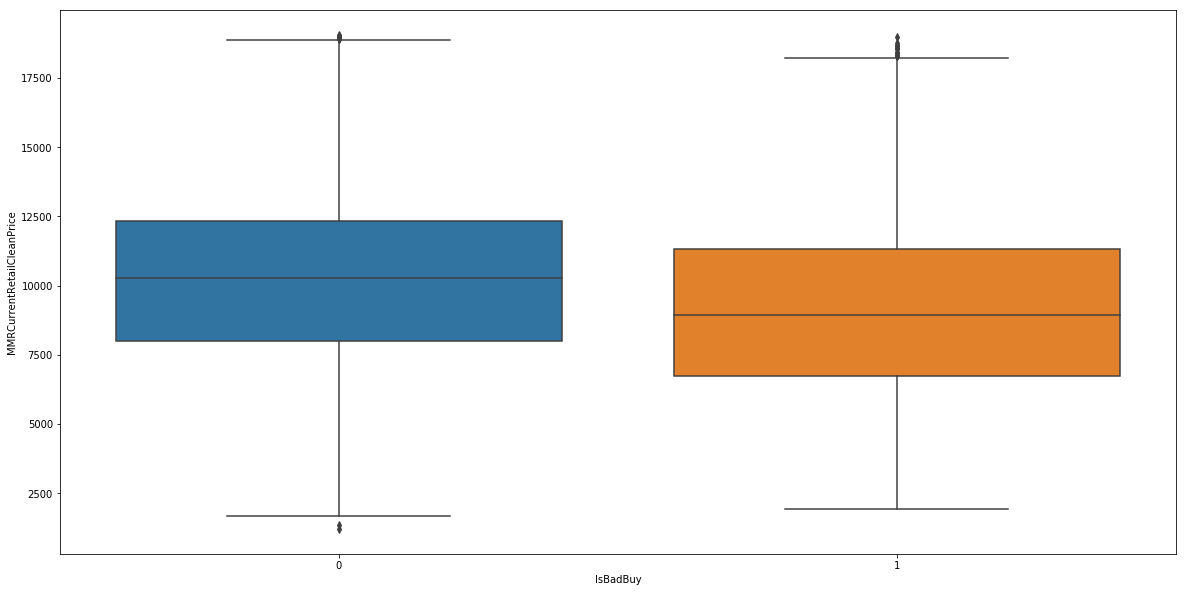

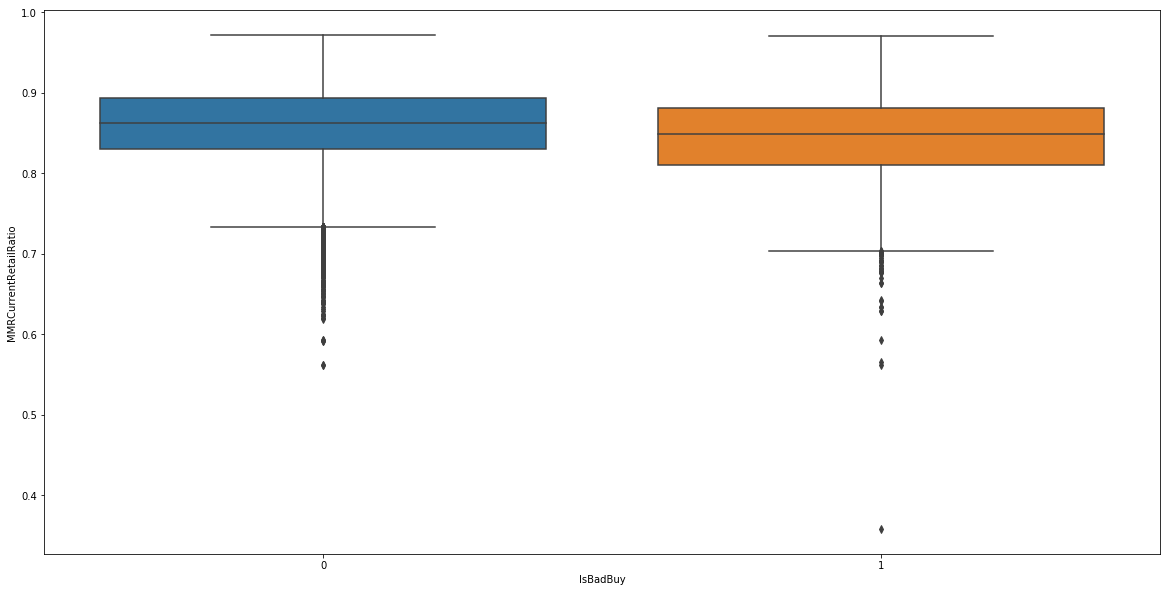

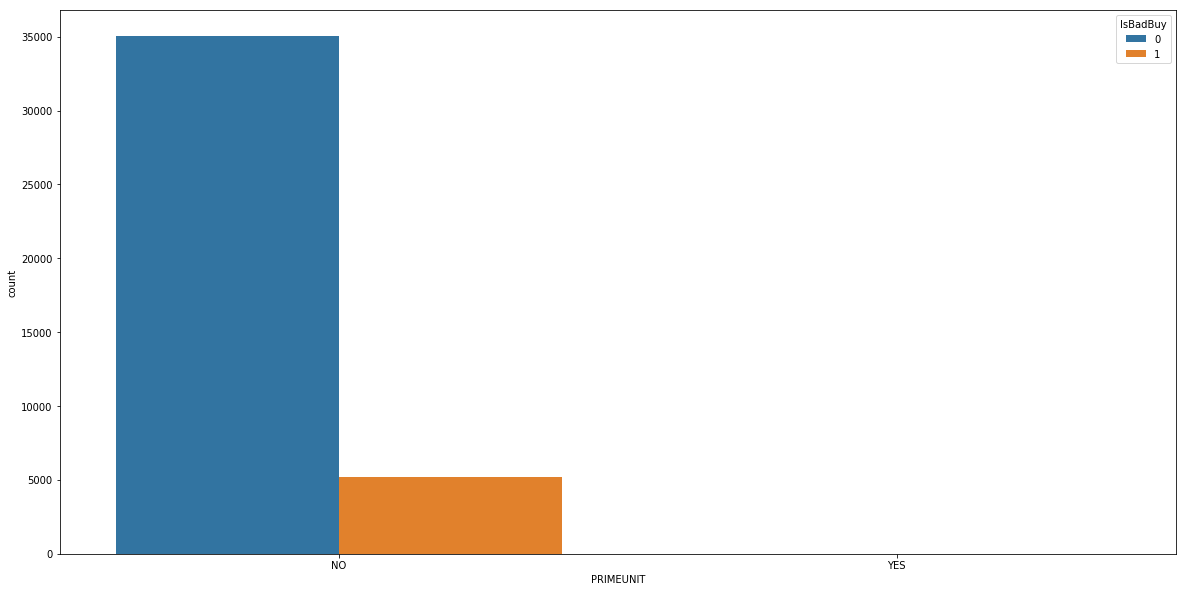

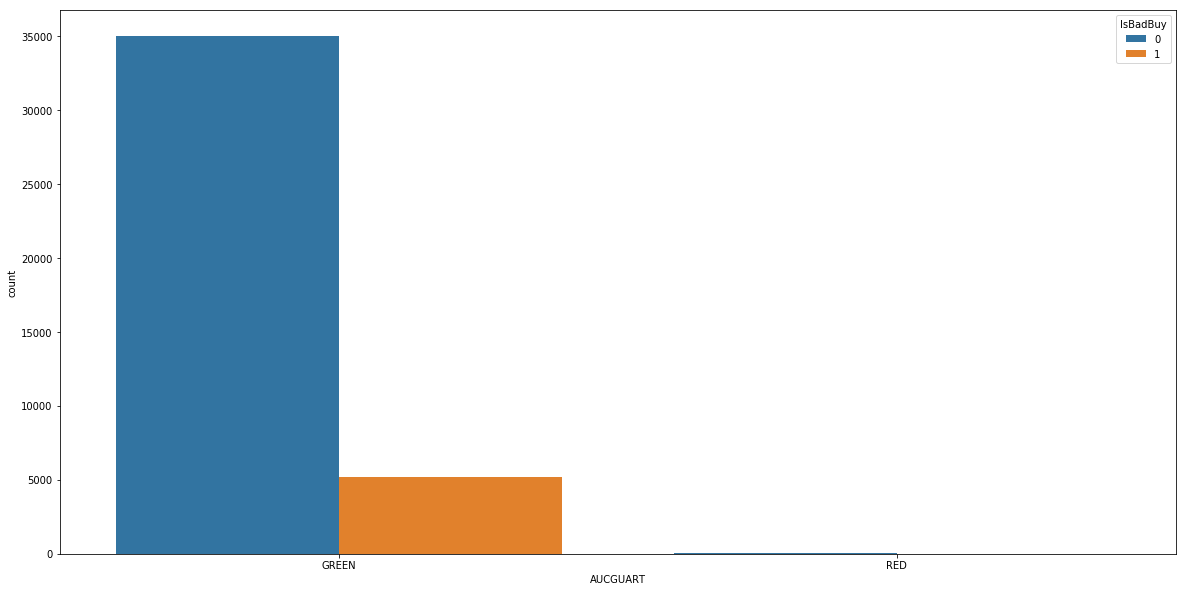

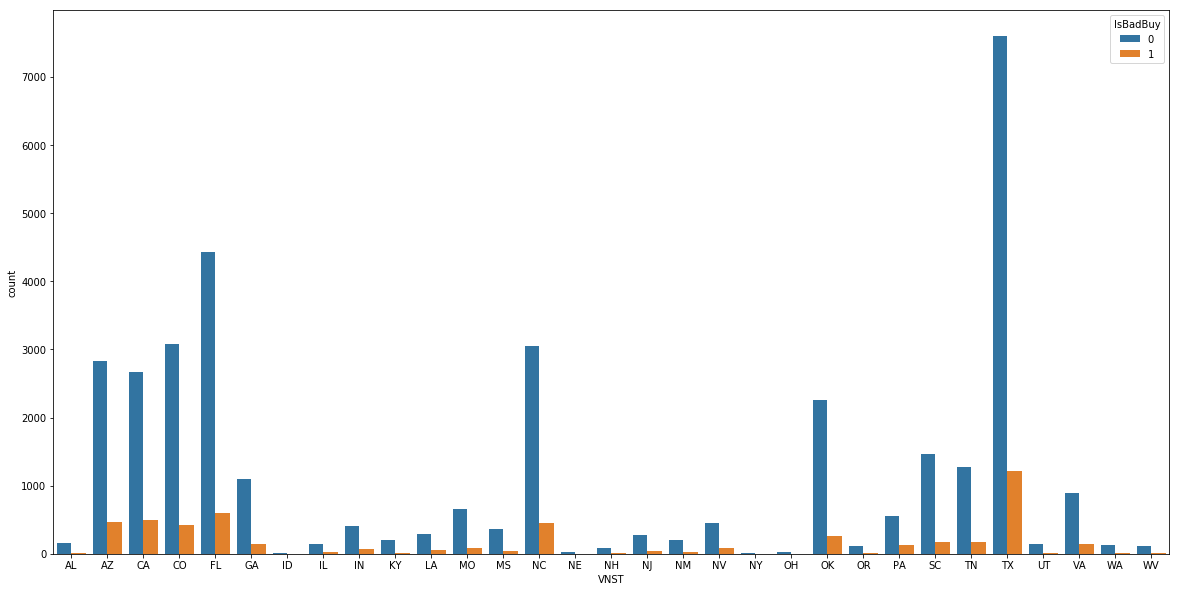

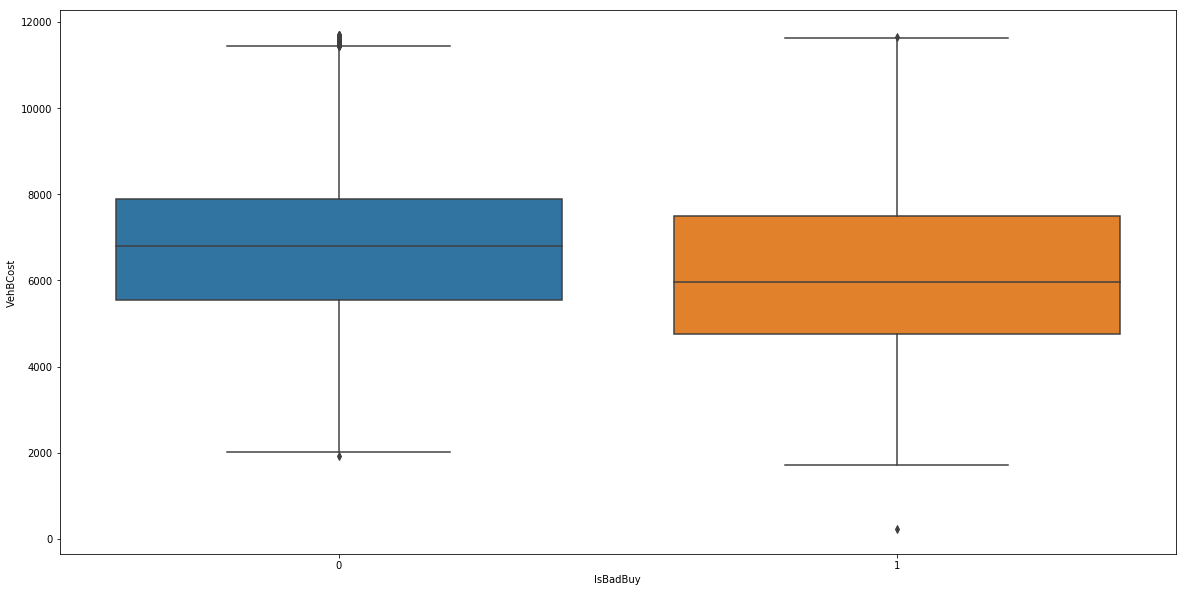

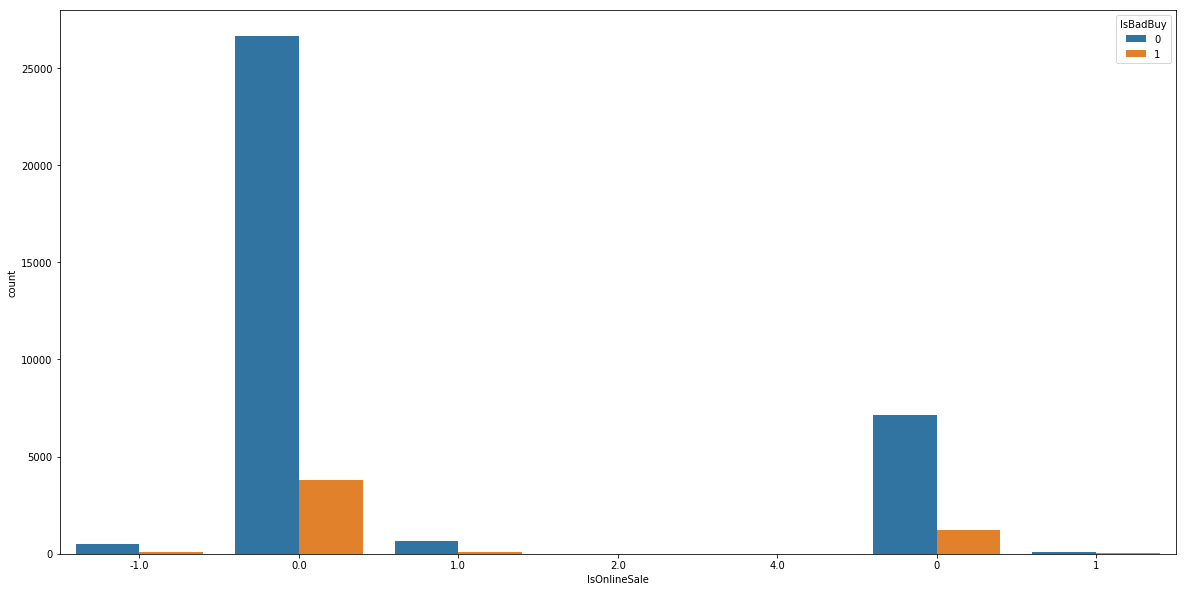

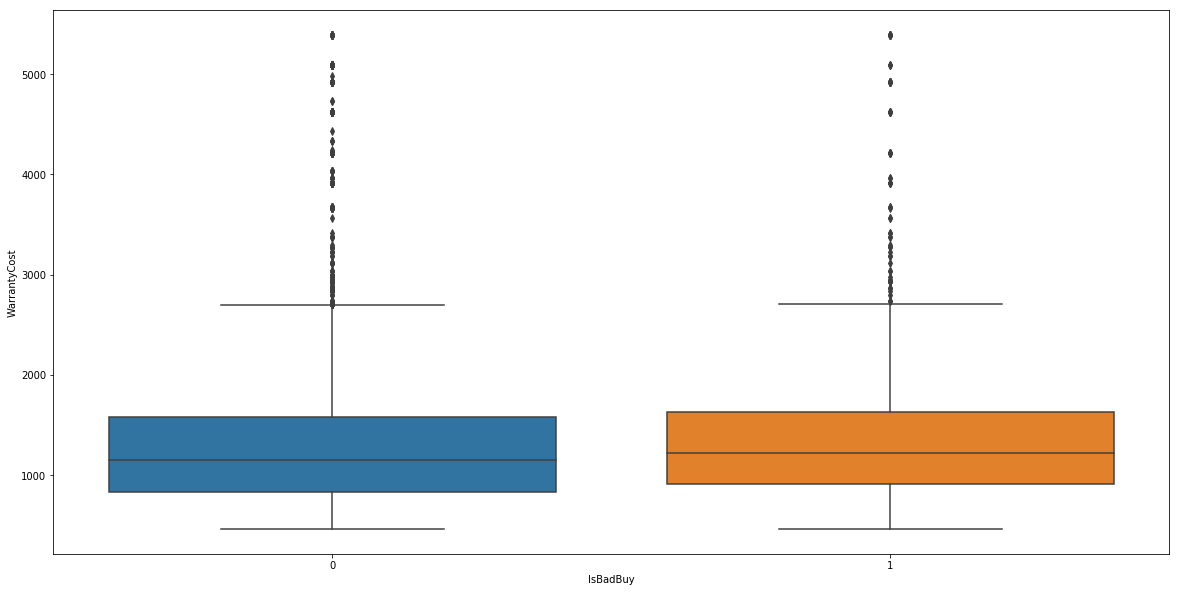

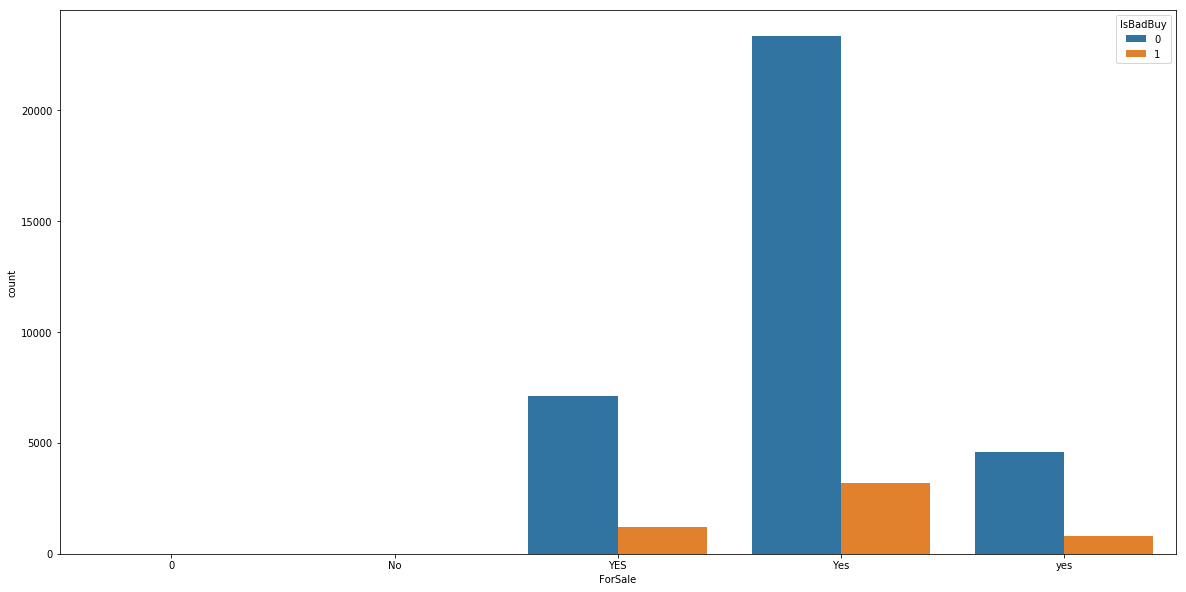

<Figure size 1440x720 with 0 Axes>

In [186]:
plotAllCols(df)

# 4. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice

# 5. What distribution scheme did you use? What data partitioning allocation did you set? Explain your selection. 

In [229]:
# Change to the dummy 
rs = 101
df = pd.get_dummies(df)
X_train, X_test, y_train, y_test = train_test_split(df.drop("IsBadBuy", axis=1), df['IsBadBuy'], test_size=0.3, stratify=df['IsBadBuy'], random_state=rs)


In [230]:
len(X_train)

28156

In [231]:
len(X_test)

12067

# Taks 2

In [ ]:
def analyse_feature_importance(dm_model, feature_names, n_to_display=20):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])

def visualize_decision_tree(dm_model, feature_names, save_name):
    dotfile = StringIO()
    export_graphviz(dm_model, out_file=dotfile, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    graph[0].write_png(save_name) # saved in the following file


In [251]:

# simple decision tree training
model = DecisionTreeClassifier(random_state=rs)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=101,
            splitter='best')

In [252]:
print("Train accuracy:", model.score(X_train, y_train))

Train accuracy: 1.0


In [253]:
print("Test accuracy:", model.score(X_test, y_test))

Test accuracy: 0.7882655175271401


In [254]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.87      0.88     10516
           1       0.21      0.24      0.22      1551

   micro avg       0.79      0.79      0.79     12067
   macro avg       0.55      0.55      0.55     12067
weighted avg       0.80      0.79      0.79     12067



In [255]:
analyse_feature_importance(model, df.drop("IsBadBuy", axis=1).columns, 20)
visualize_decision_tree(cv.best_estimator_, df.drop("IsBadBuy", axis=1).columns, "Tree_Struct.png")

VehOdo : 0.08657443670048924
VehBCost : 0.08163059862189834
PurchaseTimestamp : 0.07442091755640433
MMRCurrentRetailRatio : 0.07039795549794022
MMRAcquisitionAuctionCleanPrice : 0.05622527073255473
MMRCurrentAuctionAveragePrice : 0.051491808392621734
MMRCurrentAuctionCleanPrice : 0.04458984055869702
MMRAcquisitonRetailCleanPrice : 0.043996203245662106
MMRCurrentRetailAveragePrice : 0.04354390163709493
MMRAcquisitionAuctionAveragePrice : 0.0425963782274734
WarrantyCost : 0.042501637219834694
MMRCurrentRetailCleanPrice : 0.03786216619338647
MMRAcquisitionRetailAveragePrice : 0.03373247289875904
WheelType_alloy : 0.01637843776294047
Auction_manheim : 0.010483604212546972
VNST_tx : 0.008482288203175245
Color_silver : 0.007566382167837554
Color_white : 0.007437479726172542
Color_blue : 0.00682228477448936
Color_gold : 0.006457256438952115


In [256]:
# grid search CV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 7),
          'min_samples_leaf': range(20, 60, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

# test the best model
y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.8715016337547947
Test accuracy: 0.8714676390154968
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.00      0.00      0.00      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.44      0.50      0.47     12067
weighted avg       0.76      0.87      0.81     12067

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 20}


/Users/chihcheng/.virtualenvs/python3env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [257]:
analyse_feature_importance(cv.best_estimator_, df.drop("IsBadBuy", axis=1).columns, 20)
visualize_decision_tree(cv.best_estimator_, df.drop("IsBadBuy", axis=1).columns, "Tree_Struct_CV.png")

MMRAcquisitionAuctionCleanPrice : 0.5133718127146668
WheelType_alloy : 0.48662818728533325
Make_mercury : 0.0
Make_scion : 0.0
Make_saturn : 0.0
Make_pontiac : 0.0
Make_oldsmobile : 0.0
Make_nissan : 0.0
Make_mitsubishi : 0.0
Make_mini : 0.0
ForSale_yes : 0.0
Make_suzuki : 0.0
Make_mazda : 0.0
Make_lincoln : 0.0
Make_lexus : 0.0
Make_kia : 0.0
Make_jeep : 0.0
Make_isuzu : 0.0
Make_subaru : 0.0
Make_toyota : 0.0
